In [1]:
import os
import re
import glob
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import skimage as ski
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, LassoCV, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import seaborn as sns
from sklearn.ensemble import GradientBoostingRegressor
import pysindy as ps
import statsmodels.api as sm

In [2]:
train = pd.read_csv("C:/Users/coryg/OneDrive/Desktop/STAT_698_Thesis_Joon_Suzuki/toy_train_data.csv")
test = pd.read_csv("C:/Users/coryg/OneDrive/Desktop/STAT_698_Thesis_Joon_Suzuki/toy_test_data.csv")

In [3]:
data_X = train.drop(columns=["dfudt"])
data_y = train["dfudt"]
data_mat_X = data_X.values
data_mat_y = data_y.values

In [4]:
reg_mod = sm.OLS(data_mat_y, data_mat_X)
results = reg_mod.fit()
summary = results.summary()
print(summary)

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.914
Model:                            OLS   Adj. R-squared (uncentered):              0.914
Method:                 Least Squares   F-statistic:                          2.854e+07
Date:                Tue, 08 Jul 2025   Prob (F-statistic):                        0.00
Time:                        15:19:55   Log-Likelihood:                      3.3089e+07
No. Observations:            13464584   AIC:                                 -6.618e+07
Df Residuals:                13464579   BIC:                                 -6.618e+07
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

$ u_{t} = -0.0014u - 13.3337u_{x} + 95.2591u_{xx} $

In [5]:
lasso_ode = Lasso(alpha=0.1)
lasso_ode.fit(data_mat_X, data_mat_y)
print("lasso coefficients: ", lasso_ode.coef_)

lasso coefficients:  [-0. -0. -0.  0. -0.]


In [6]:
# Computing prediction accuracy from testing set. 

y_pred_ode = lasso_ode.predict(data_mat_X)
mse_ode = mean_squared_error(data_mat_y, y_pred_ode)
print("Mean Squared Error:", mse_ode)

Mean Squared Error: 0.0049814167281995655


In [8]:
# Tuning alpha parameter via CV with cv=5 folds. 

lasso_cv_ode = LassoCV(alphas=np.logspace(-3,1,100), cv=5)
lasso_cv_ode.fit(data_mat_X, data_mat_y)

print("Optimal alpha:", lasso_cv_ode.alpha_)

Optimal alpha: 0.001


In [9]:
# Checking number of zero coefficients (how many features dropped)

check = sum(lasso_cv_ode.coef_ == 0)
check

4

In [10]:
# LASSO Regularized regression for feature selection.

lasso_ode = Lasso(alpha=lasso_cv_ode.alpha_)
lasso_ode.fit(data_mat_X, data_mat_y)

print("LASSO Coefficients:", lasso_ode.coef_)

LASSO Coefficients: [-0.00925312 -0.         -0.          0.         -0.        ]


In [6]:
data_mat_X = train.drop(columns=["u", "dy", "dxx", "dyy", "dfudt"])
data_mat_X.values

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]])

In [7]:
reg_mod2 = sm.OLS(data_mat_y, data_mat_X)
results2 = reg_mod2.fit()
summary2 = results2.summary()
print(summary2)

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.896
Model:                            OLS   Adj. R-squared (uncentered):              0.896
Method:                 Least Squares   F-statistic:                          1.166e+08
Date:                Tue, 08 Jul 2025   Prob (F-statistic):                        0.00
Time:                        15:20:19   Log-Likelihood:                      3.1859e+07
No. Observations:            13464584   AIC:                                 -6.372e+07
Df Residuals:                13464583   BIC:                                 -6.372e+07
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [8]:
from scipy.ndimage import gaussian_filter

def forward_euler_pde_mixed(u0, dx, dy, dt, steps):
    """
    Forward Euler integration for the PDE:
    u_t = 0.0321u - 10.9031u_x - 3.3925u_xy + 138.6948u_xx
    
    Parameters:
        u0: np.ndarray, initial image
        dx, dy: spatial resolutions
        dt: time step
        steps: number of steps (e.g., 5 for Image_51 to Image_55)
        
    Returns:
        List of predicted images
    """
    u = u0.copy()
    images = [u.copy()]
    
    for _ in range(steps):
        # First derivative in x
        u_x = (np.roll(u, -1, axis=0) - np.roll(u, 1, axis=0)) / (2 * dx)
        
        # Second derivative in x
        u_xx = (np.roll(u, -1, axis=0) - 2*u + np.roll(u, 1, axis=0)) / (dx**2)

        # Second derivative in y
        u_yy = (np.roll(u, -1, axis=1) - 2*u + np.roll(u, 1, axis=1)) / (dy**2)
        
        
        # Time derivative

        # Data Driven
        u_t = (-0.0014 * u - 13.3337 * u_x + 95.2591 * u_xx - 0.0030 * u_yy)

        # Physics Driven
        # u_t = (-13.3348 * u_x)
        
        # Forward Euler update
        u = u + dt * u_t
        #u = gaussian_filter(u, sigma=1)
        images.append(u.copy())
    
    return images

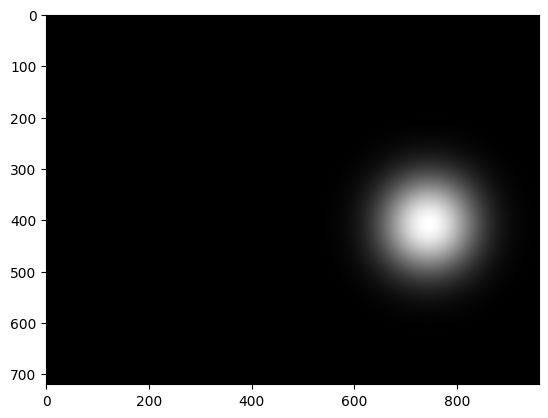

In [9]:
h = 1

image_45 = ski.io.imread("C:/Users/coryg/OneDrive/Desktop/STAT_698_Thesis_Joon_Suzuki/Toy_Example_Data/moving_square_45.jpg", as_gray=True)
image_45 = np.where(image_45 == 1, 0, 1)
image_45 = ski.filters.gaussian(image_45, sigma=55)
image_45 = image_45 * 1e10
plt.imshow(image_45, cmap="gray")

dx45 = np.gradient(image_45, h, axis=1)
dy45 = np.gradient(image_45, h, axis=0)
dxx45 = np.gradient(dx45, h, axis=1)
dyy45 = np.gradient(dy45, h, axis=0)

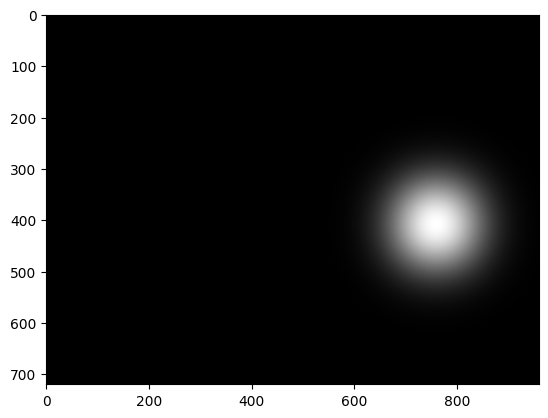

In [10]:
image_46 = ski.io.imread("C:/Users/coryg/OneDrive/Desktop/STAT_698_Thesis_Joon_Suzuki/Toy_Example_Data/moving_square_46.jpg", as_gray=True)
image_46 = np.where(image_46 == 1, 0, 1)
image_46 = ski.filters.gaussian(image_46, sigma=55)
image_46 = image_46 * 1e10
plt.imshow(image_46, cmap="gray")

dx46 = np.gradient(image_46, h, axis=1)
dy46 = np.gradient(image_46, h, axis=0)
dxx46 = np.gradient(dx46, h, axis=1)
dyy46 = np.gradient(dy46, h, axis=0)

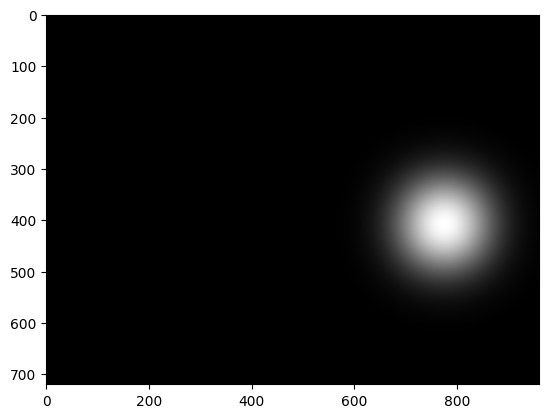

In [11]:
image_47 = ski.io.imread("C:/Users/coryg/OneDrive/Desktop/STAT_698_Thesis_Joon_Suzuki/Toy_Example_Data/moving_square_47.jpg", as_gray=True)
image_47 = np.where(image_47 == 1, 0, 1)
image_47 = ski.filters.gaussian(image_47, sigma=55)
image_47 = image_47 * 1e10
plt.imshow(image_47, cmap="gray")

dx47 = np.gradient(image_47, h, axis=1)
dy47 = np.gradient(image_47, h, axis=0)
dxx47 = np.gradient(dx47, h, axis=1)
dyy47 = np.gradient(dy47, h, axis=0)

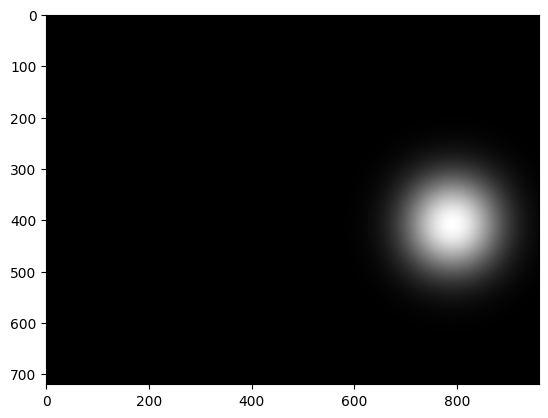

In [12]:
image_48 = ski.io.imread("C:/Users/coryg/OneDrive/Desktop/STAT_698_Thesis_Joon_Suzuki/Toy_Example_Data/moving_square_48.jpg", as_gray=True)
image_48 = np.where(image_48 == 1, 0, 1)
image_48 = ski.filters.gaussian(image_48, sigma=55)
image_48 = image_48 * 1e10
plt.imshow(image_48, cmap="gray")

dx48 = np.gradient(image_48, h, axis=1)
dy48 = np.gradient(image_48, h, axis=0)
dxx48 = np.gradient(dx48, h, axis=1)
dyy48 = np.gradient(dy48, h, axis=0)

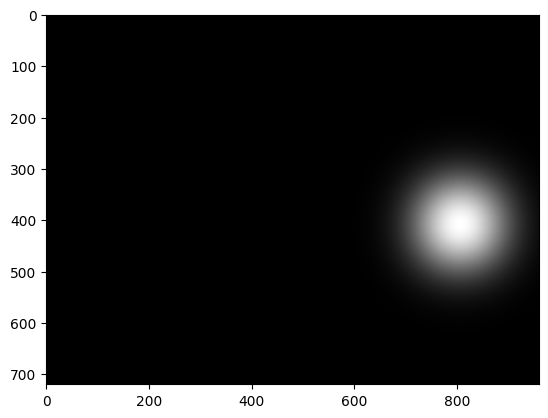

In [13]:
image_49 = ski.io.imread("C:/Users/coryg/OneDrive/Desktop/STAT_698_Thesis_Joon_Suzuki/Toy_Example_Data/moving_square_49.jpg", as_gray=True)
image_49 = np.where(image_49 == 1, 0, 1)
image_49 = ski.filters.gaussian(image_49, sigma=55)
image_49 = image_49 * 1e10
plt.imshow(image_49, cmap="gray")

dx49 = np.gradient(image_49, h, axis=1)
dy49 = np.gradient(image_49, h, axis=0)
dxx49 = np.gradient(dx49, h, axis=1)
dyy49 = np.gradient(dy49, h, axis=0)

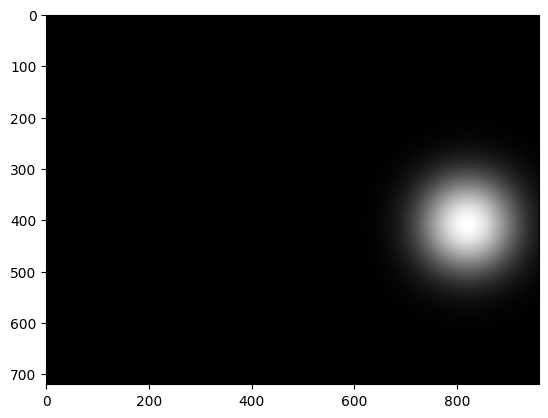

In [14]:
image_50 = ski.io.imread("C:/Users/coryg/OneDrive/Desktop/STAT_698_Thesis_Joon_Suzuki/Toy_Example_Data/moving_square_50.jpg", as_gray=True)
image_50 = np.where(image_50 == 1, 0, 1)
image_50 = ski.filters.gaussian(image_50, sigma=55)
image_50 = image_50 * 1e10
plt.imshow(image_50, cmap="gray")

dx50 = np.gradient(image_50, h, axis=1)
dy50 = np.gradient(image_50, h, axis=0)
dxx50 = np.gradient(dx50, h, axis=1)
dyy50 = np.gradient(dy50, h, axis=0)

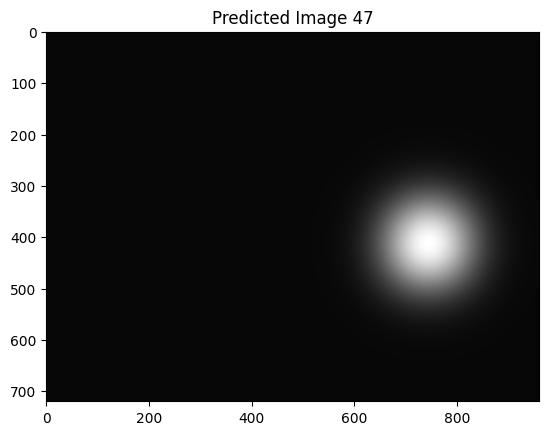

In [15]:
dx = dxx = 1.0
dt = 0.1   # You can reduce this if the solution becomes unstable
steps = 5

predicted_images = forward_euler_pde_mixed(image_45, dx, dxx, dt, steps)

# View Image 53
import matplotlib.pyplot as plt
plt.imshow(predicted_images[3], cmap='gray')
plt.title("Predicted Image 47")
plt.show()

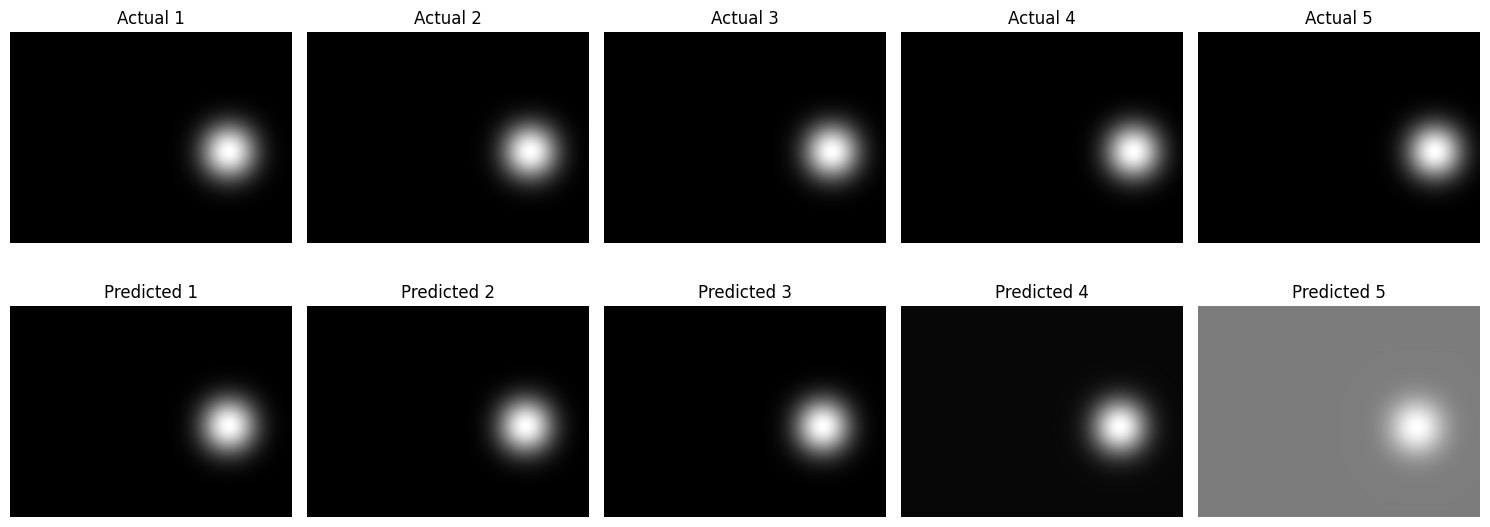

In [17]:
truth = [image_45, image_46, image_47, image_48, image_49, image_50]
predicted = [predicted_images[i] for i in range(1, 6)]

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    
for i in range(5):
        # Actual images on the top row
    axes[0, i].imshow(truth[i], cmap='gray')
    axes[0, i].set_title(f"Actual {i+1}")
    axes[0, i].axis('off')
        
        # Predicted images on the bottom row
    axes[1, i].imshow(predicted_images[i], cmap='gray')
    axes[1, i].set_title(f"Predicted {i+1}")
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


(-0.5, 959.5, 719.5, -0.5)

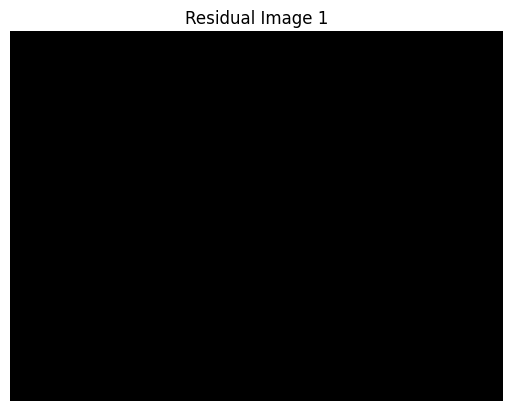

In [18]:
residual = truth[0] - predicted_images[0]
print(residual)
plt.imshow(residual, cmap='gray')
plt.title("Residual Image 1")
plt.axis('off')

(-0.5, 959.5, 719.5, -0.5)

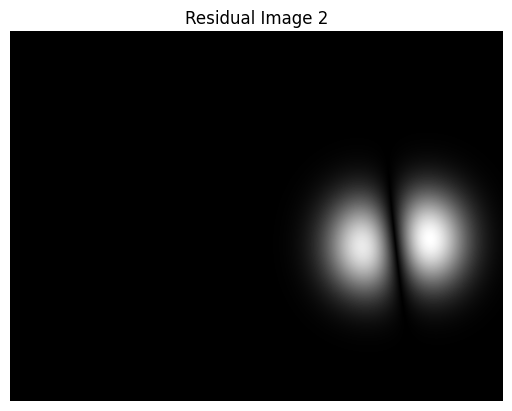

In [19]:
residual2 = np.abs(truth[1] - predicted_images[1])
plt.imshow(residual2, cmap='gray')
plt.title("Residual Image 2")
plt.axis('off')

(-0.5, 959.5, 719.5, -0.5)

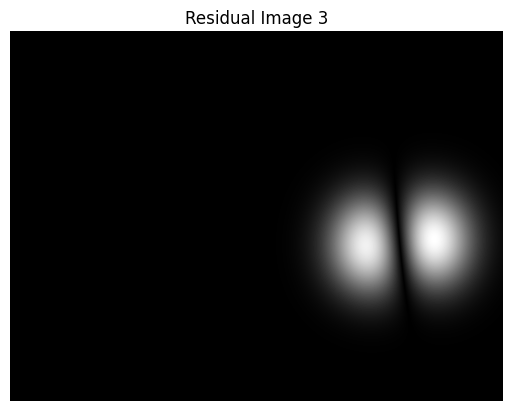

In [20]:
residual3 = np.abs(truth[2] - predicted_images[2])
plt.imshow(residual3, cmap='gray')
plt.title("Residual Image 3")
plt.axis('off')

(-0.5, 959.5, 719.5, -0.5)

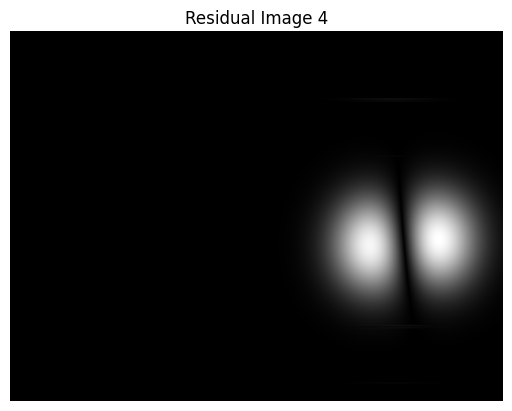

In [21]:
residual4 = np.abs(truth[3] - predicted_images[3])
plt.imshow(residual4, cmap='gray')
plt.title("Residual Image 4")
plt.axis('off')

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


(-0.5, 959.5, 719.5, -0.5)

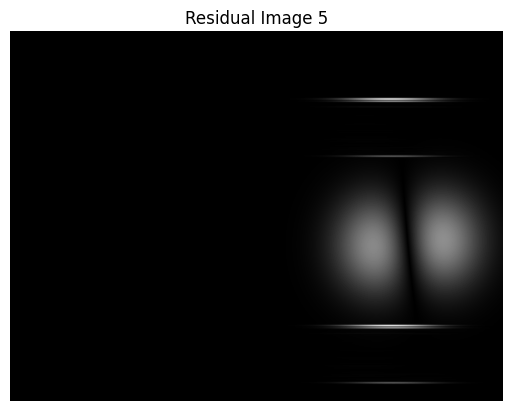

In [22]:
residual5 = np.abs(truth[4] - predicted_images[4])
print(residual5)
plt.imshow(residual5, cmap='gray')
plt.title("Residual Image 5")
plt.axis('off')

In [23]:
mse1 = np.mean(residual**2)
mse2 = np.mean(residual2**2)
mse3 = np.mean(residual3**2)
mse4 = np.mean(residual4**2)
mse5 = np.mean(residual5**2)

mse1, mse2, mse3, mse4, mse5

(0.0,
 0.002444027857075766,
 0.009940855588957475,
 0.022104886805052765,
 0.042498639115586156)